In [22]:
!pip install xgboost --quiet

In [ ]:
###  Data Extraction

In [23]:
# Cell 1: Imports and Settings
import pandas as pd
from datetime import timedelta

In [24]:

# Example usage:
zip_file = '/content/synthea-patient.zip'  # Replace with the actual path to your zip file
extraction_directory = '/content/data' # Replace with the desired extraction directory

!mkdir -p "{extraction_directory}" # Create the extraction directory if it doesn't exist
!unzip -o "{zip_file}" -d "{extraction_directory}"

unzip:  cannot find or open /content/synthea-patient.zip, /content/synthea-patient.zip.zip or /content/synthea-patient.zip.ZIP.


In [25]:
# Cell 2: Define file paths and load the datasets
base = r'/content/data'
patients_path   = f"{base}/patients.csv"
conditions_path = f"{base}/conditions.csv"
encounters_path = f"{base}/encounters.csv"
obs_path        = f"{base}/observations.csv"

patients = pd.read_csv(
    patients_path,
    parse_dates=['BIRTHDATE', 'DEATHDATE']
)
conditions = pd.read_csv(
    conditions_path,
    parse_dates=['START', 'STOP']
)
encounters = pd.read_csv(
    encounters_path,
    parse_dates=['START', 'STOP']
)

In [26]:
# Cell 3: Preview raw data
print("Patients sample:")
print(patients.head(), "\n")
print("Conditions sample:")
print(conditions.head(), "\n")
print("Encounters sample:")
print(encounters.head(), "\n")

Patients sample:
                                     Id  BIRTHDATE  DEATHDATE          SSN  \
0  5605b66b-e92d-c16c-1b83-b8bf7040d51f 1977-03-19        NaT  999-94-9633   
1  c06a2ab3-c3b1-a3d0-7c12-262a12c6885e 1936-07-03        NaT  999-76-5032   
2  6e5ae27c-8038-7988-e2c0-25a103f01bfa 1940-02-19        NaT  999-83-7940   
3  94d39619-8e17-d248-41b3-9ec1f2d031b2 1954-11-08 2010-01-10  999-84-3708   
4  23832f5d-e045-2541-1626-a65dce9bbcf7 1972-04-13        NaT  999-89-5858   

     DRIVERS    PASSPORT PREFIX           FIRST           LAST SUFFIX  ...  \
0  S99930485  X51431379X   Mrs.       Nikita578      Erdman779    NaN  ...   
1  S99927160  X37795263X    Mr.  Miguel Ángel46     Atencio773    NaN  ...   
2  S99932661  X36822066X    Mr.         Zane918  Hodkiewicz467    NaN  ...   
3  S99923522  X49705907X    Mr.       Emmett200     Collins926    NaN  ...   
4  S99939931  X88479701X   Mrs.        Magan944       Green467    NaN  ...   

                        BIRTHPLACE           

In [27]:
# Cell 4: Label lung-related conditions
snomed_codes = ['233604007', '195967001', '13645005']  # pneumonia, asthma, COPD
keywords = ['pneumonia', 'chronic obstructive', 'COPD', 'asthma']
pattern = '|'.join(keywords)
conditions['lung_label'] = (
    conditions['CODE'].astype(str).isin(snomed_codes)
    | conditions['DESCRIPTION'].str.contains(pattern, case=False, na=False)
)

In [28]:
# Cell 5: Inspect flagged lung-condition records
lung_positive = conditions[conditions['lung_label']]
print("Flagged lung conditions:")
print(lung_positive[['PATIENT','CODE','DESCRIPTION','START']].head(), "\n")

Flagged lung conditions:
                                   PATIENT       CODE           DESCRIPTION  \
1008  ad362b64-31b4-8fa3-c760-38d0e5cacc1c  233604007             Pneumonia   
1216  febefd51-6130-5e0e-34ed-2ccce47be271  233604007  Pneumonia (disorder)   
1416  a4e89ca1-2d08-a775-cd47-526bbc80f6ea  233604007             Pneumonia   
2159  2853ca5a-7862-68c8-07d1-3d7fa2d6ae27  233604007             Pneumonia   
2334  84a69a69-4309-1549-de32-083332b13d56  195967001                Asthma   

          START  
1008 2012-12-12  
1216 2020-11-06  
1416 2017-04-24  
2159 2017-07-20  
2334 1997-01-20   



In [29]:
# Cell 6: Aggregate per-patient labels and first-positive condition
patients.rename(columns={'Id':'patient_id'}, inplace=True)
cohort = (
    conditions
    .groupby('PATIENT', as_index=False)['lung_label']
    .max()
    .rename(columns={'PATIENT':'patient_id'})
)
first_lung = (
    conditions[conditions['lung_label']]
    .sort_values(['PATIENT','START'])
    .groupby('PATIENT', as_index=False)
    .first()[['PATIENT','CODE','DESCRIPTION']]
    .rename(columns={
        'PATIENT':'patient_id',
        'CODE':'first_lung_code',
        'DESCRIPTION':'first_lung_description'
    })
)
cohort = cohort.merge(first_lung, on='patient_id', how='left')
cohort = cohort.merge(patients, on='patient_id', how='left')

In [30]:
# Cell 7: Save base cohort
cohort.to_csv('cohort.csv', index=False)
print("Cohort saved to cohort.csv")
print(cohort.head(), "\n")

Cohort saved to cohort.csv
                             patient_id  lung_label  first_lung_code  \
0  0007b281-7eb0-f2b2-d12a-3fc1e2f7e3e2       False              NaN   
1  0007efd3-c50d-7e51-6a30-8dc08d4269fc        True      233604007.0   
2  000eba84-0d5c-2657-0b5e-0c70f2f746c2       False              NaN   
3  000f23c8-470d-babb-5fda-2b13c6c54e80       False              NaN   
4  0011c542-8a54-27c3-59d6-1575d265210e       False              NaN   

  first_lung_description  BIRTHDATE  DEATHDATE          SSN    DRIVERS  \
0                    NaN 1950-01-27 2001-12-14  999-38-9527  S99999004   
1   Pneumonia (disorder) 1963-11-25        NaT  999-91-3685  S99920576   
2                    NaN 1929-04-06        NaT  999-18-7950  S99957211   
3                    NaN 1938-07-22        NaT  999-18-9795  S99962765   
4                    NaN 1965-02-10        NaT  999-13-2355  S99966163   

     PASSPORT PREFIX  ...                           BIRTHPLACE  \
0  X36466268X    Ms.  ...    

In [31]:
# Cell 7: DEBUG – Inspect cohort after merging labels & demographics
print("➤ Cohort shape:", cohort.shape)
print("\n➤ Lung_label counts:\n", cohort['lung_label'].value_counts(dropna=False), "\n")
print("➤ Sample cohort rows:\n", cohort.head(), "\n")


➤ Cohort shape: (15354, 28)

➤ Lung_label counts:
 lung_label
False    14126
True      1228
Name: count, dtype: int64 

➤ Sample cohort rows:
                              patient_id  lung_label  first_lung_code  \
0  0007b281-7eb0-f2b2-d12a-3fc1e2f7e3e2       False              NaN   
1  0007efd3-c50d-7e51-6a30-8dc08d4269fc        True      233604007.0   
2  000eba84-0d5c-2657-0b5e-0c70f2f746c2       False              NaN   
3  000f23c8-470d-babb-5fda-2b13c6c54e80       False              NaN   
4  0011c542-8a54-27c3-59d6-1575d265210e       False              NaN   

  first_lung_description  BIRTHDATE  DEATHDATE          SSN    DRIVERS  \
0                    NaN 1950-01-27 2001-12-14  999-38-9527  S99999004   
1   Pneumonia (disorder) 1963-11-25        NaT  999-91-3685  S99920576   
2                    NaN 1929-04-06        NaT  999-18-7950  S99957211   
3                    NaN 1938-07-22        NaT  999-18-9795  S99962765   
4                    NaN 1965-02-10        NaT  999-13

In [32]:
# Cell 8: Feature Engineering — Compute age at first encounter and current/at-death age

import pandas as pd

# ─── Ensure first_start exists ────────────────────────────────────────────────
if 'first_start' not in cohort.columns:
    first_enc = (
        encounters
        .groupby('PATIENT', as_index=False)['START']
        .min()
        .rename(columns={'PATIENT':'patient_id','START':'first_start'})
    )
    cohort = cohort.merge(first_enc, on='patient_id', how='left')

# ─── Strip tz and compute age at first encounter ──────────────────────────────
cohort['BIRTHDATE']   = pd.to_datetime(cohort['BIRTHDATE']).dt.tz_localize(None)
cohort['first_start'] = pd.to_datetime(cohort['first_start']).dt.tz_localize(None)
cohort['age_event']   = (cohort['first_start'] - cohort['BIRTHDATE']).dt.days / 365.25

# ─── Compute current/at-death age ─────────────────────────────────────────────
# Ensure DEATHDATE is datetime & tz-naive
cohort['DEATHDATE'] = pd.to_datetime(cohort['DEATHDATE']).dt.tz_localize(None)
# Define “today” or analysis cutoff
today = pd.Timestamp.today().normalize()
# Use DEATHDATE if present, otherwise today
end_date = cohort['DEATHDATE'].fillna(today)
cohort['age_current'] = (end_date - cohort['BIRTHDATE']).dt.days / 365.25

# ─── DEBUG: inspect the two age metrics before filtering ───────────────────────
print("Age at event summary:")
print(cohort['age_event'].describe(), "\n")
print("Current/at-death age summary:")
print(cohort['age_current'].describe(), "\n")
print("Sample age values:")
print(cohort[['patient_id','BIRTHDATE','first_start','age_event','DEATHDATE','age_current']].head(10), "\n")

# ─── Filter to adults (age ≥ 18 at first encounter) ──────────────────────────
cohort = cohort[cohort['age_event'] >= 18]
print(f"➤ Patients remaining after age_event ≥ 18 filter: {cohort.shape[0]}\n")


Age at event summary:
count    15354.000000
mean        13.304375
std          6.321151
min          0.000000
25%          9.559206
50%         17.133470
75%         18.149213
max         19.167693
Name: age_event, dtype: float64 

Current/at-death age summary:
count    15354.000000
mean        67.217791
std         20.586787
min          0.000000
25%         51.919233
50%         68.737851
75%         83.884326
max        103.200548
Name: age_current, dtype: float64 

Sample age values:
                             patient_id  BIRTHDATE         first_start  \
0  0007b281-7eb0-f2b2-d12a-3fc1e2f7e3e2 1950-01-27 1968-03-22 15:35:11   
1  0007efd3-c50d-7e51-6a30-8dc08d4269fc 1963-11-25 1981-06-23 06:45:29   
2  000eba84-0d5c-2657-0b5e-0c70f2f746c2 1929-04-06 1929-10-11 04:41:09   
3  000f23c8-470d-babb-5fda-2b13c6c54e80 1938-07-22 1956-09-14 13:01:28   
4  0011c542-8a54-27c3-59d6-1575d265210e 1965-02-10 1966-07-09 01:53:25   
5  001209d3-9cd3-a700-69ea-c9982213efea 1926-11-27 1945-01-20 2

In [33]:
# Cell 9: Feature Engineering — Inpatient‐stay filter + debug
# DEBUG: show available encounter classes
print("Encounter classes available:", encounters['ENCOUNTERCLASS'].unique(), "\n")

# Filter to patients with at least one inpatient stay
mask_ip = (
    encounters['PATIENT'].isin(cohort['patient_id']) &
    (encounters['ENCOUNTERCLASS'].str.lower() == 'inpatient')
)
inpatient_patients = encounters.loc[mask_ip, 'PATIENT'].unique()
print(f"➤ Unique inpatient patient count: {len(inpatient_patients)}\n")

cohort = cohort[cohort['patient_id'].isin(inpatient_patients)]
print(f"➤ Patients remaining after inpatient-stay filter: {cohort.shape[0]}\n")

Encounter classes available: ['wellness' 'inpatient' 'ambulatory' 'outpatient' 'urgentcare' 'emergency'
 'snf' 'hospice' 'home'] 

➤ Unique inpatient patient count: 2631

➤ Patients remaining after inpatient-stay filter: 2631



In [34]:
# Cell 10: Feature Engineering — Comorbidity Counts

# Count distinct condition codes per patient
comorbidity_counts = (
    conditions
    .groupby('PATIENT')['CODE']
    .nunique()
    .reset_index()
    .rename(columns={'PATIENT':'patient_id', 'CODE':'num_comorbidities'})
)

# Merge into cohort
cohort = cohort.merge(comorbidity_counts, on='patient_id', how='left')

print("Added num_comorbidities; sample:")
print(cohort[['patient_id','num_comorbidities']].head(), "\n")

Added num_comorbidities; sample:
                             patient_id  num_comorbidities
0  005444f1-853d-ad2e-2ee6-b772b4bb8014                 24
1  007b9335-08e2-c478-a79a-d9d4b6e88f62                 16
2  009f3a51-db42-bb8d-daad-a03c46387522                 14
3  00ab49d7-9776-b5fd-abbd-5151ca805afb                 21
4  00b9b7eb-5bd2-718c-4966-2dabcc2a1528                 12 



In [35]:
# Cell 11: Feature Engineering — One-hot encode Race & Ethnicity (deduplicated)

# 1) Drop any pre-existing race_/ethnicity_ columns to avoid duplicates
drop_cols = [c for c in cohort.columns if c.startswith('race_') or c.startswith('ethnicity_')]
cohort = cohort.drop(columns=drop_cols, errors='ignore')

# 2) Build one-hot dummies for RACE and ETHNICITY
race_ethn_dummies = pd.get_dummies(
    cohort[['RACE','ETHNICITY']],
    prefix=['race','ethnicity'],
    dummy_na=False
)

# 3) Attach patient_id for merging
race_ethn_dummies['patient_id'] = cohort['patient_id'].values

# 4) Merge the fresh dummies back into cohort
cohort = cohort.merge(race_ethn_dummies, on='patient_id', how='left')

# 5) Preview
print("Added race & ethnicity dummies; sample:")
print(cohort.filter(regex='^(race_|ethnicity_)').head(), "\n")


Added race & ethnicity dummies; sample:
   race_asian  race_black  race_hawaiian  race_native  race_other  race_white  \
0       False       False          False        False       False        True   
1       False       False          False        False       False        True   
2       False       False          False        False       False        True   
3       False       False          False        False       False        True   
4       False       False          False        False       False        True   

   ethnicity_hispanic  ethnicity_nonhispanic  
0               False                   True  
1               False                   True  
2               False                   True  
3               False                   True  
4               False                   True   



In [36]:
# Cell 12 (edited): Feature Engineering — Pruned Observations Aggregation

# Path to observations file (from Cell 2)
obs_file = f"{base}/observations.csv"

# Prepare mapping of patient → first_start
first_start_map = cohort.set_index('patient_id')['first_start'].to_dict()
patient_set     = set(first_start_map)

feature_chunks = []
reader = pd.read_csv(
    obs_file,
    usecols=['PATIENT','DATE','CODE','VALUE'],
    parse_dates=['DATE'],
    chunksize=10**6
)

for i, chunk0 in enumerate(reader, start=1):
    # 1) PATIENT filter (make an explicit copy)
    chunk1 = chunk0[chunk0['PATIENT'].isin(patient_set)].copy()
    if chunk1.empty:
        print(f"Chunk #{i}: total={len(chunk0)}, after PATIENT filter=0, after window filter=0")
        continue

    # 2) map first_start and drop tz on both columns
    chunk1.loc[:, 'first_start'] = (
        pd.to_datetime(chunk1['PATIENT'].map(first_start_map))
          .dt.tz_localize(None)
    )
    chunk1.loc[:, 'DATE'] = chunk1['DATE'].dt.tz_localize(None)

    # 3) time‐window filter [first_start, first_start + 48h]
    window = chunk1['first_start'] + pd.Timedelta(hours=48)
    mask   = (chunk1['DATE'] >= chunk1['first_start']) & (chunk1['DATE'] <= window)
    chunk2 = chunk1.loc[mask]

    # Debug print
    print(f"Chunk #{i}: total={len(chunk0)}, "
          f"after PATIENT filter={len(chunk1)}, "
          f"after window filter={len(chunk2)}")

    if chunk2.empty:
        continue

    # 4) coerce VALUE to numeric & drop non‐numeric
    chunk2.loc[:, 'VALUE'] = pd.to_numeric(chunk2['VALUE'], errors='coerce')
    chunk2 = chunk2.dropna(subset=['VALUE'])
    if chunk2.empty:
        continue

    # 5) pivot to get mean/min/max per CODE
    pt = chunk2.pivot_table(
        index='PATIENT',
        columns='CODE',
        values='VALUE',
        aggfunc=['mean','min','max']
    )
    pt.columns = [f"{stat}_{code}" for stat, code in pt.columns]
    pt = pt.reset_index().rename(columns={'PATIENT':'patient_id'})
    feature_chunks.append(pt)

# 6) concatenate & reduce
if feature_chunks:
    obs_concat   = pd.concat(feature_chunks, ignore_index=True)
    obs_features = obs_concat.groupby('patient_id', as_index=False).max()
else:
    obs_features = pd.DataFrame(columns=['patient_id'])

# 7) drop any old obs cols before merge
obs_cols = [c for c in cohort.columns if c.startswith(('mean_','min_','max_'))]
cohort  = cohort.drop(columns=obs_cols, errors='ignore')

# 8) merge in the fresh ones
cohort = cohort.merge(obs_features, on='patient_id', how='left')

print("Merged observation-based features; sample:")
print(cohort.filter(regex='^(mean|min|max)_').head(), "\n")


<ipython-input-36-7026cc2297fc>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2000-04-10 19:56:11', '2000-04-10 19:56:11', '2000-04-10 19:56:11',
 '2000-04-10 19:56:11', '2000-04-10 19:56:11', '2000-04-10 19:56:11',
 '2000-04-10 19:56:11', '2000-04-10 19:56:11', '2000-04-10 19:56:11',
 '2000-04-10 19:56:11',
 ...
 '2013-11-04 06:29:28', '2013-11-04 06:29:28', '2013-11-04 06:29:28',
 '2013-11-18 15:44:02', '2012-01-28 15:44:02', '2013-01-28 15:44:02',
 '2012-01-28 15:44:02', '2013-01-28 15:44:02', '2012-01-28 15:44:02',
 '2013-01-28 15:44:02']
Length: 248396, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  chunk1.loc[:, 'DATE'] = chunk1['DATE'].dt.tz_localize(None)


Chunk #1: total=1000000, after PATIENT filter=248396, after window filter=0


<ipython-input-36-7026cc2297fc>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2004-02-09 15:44:02', '2004-02-09 15:44:02', '2004-02-09 15:44:02',
 '2004-02-09 15:44:02', '2004-02-09 15:44:02', '2004-02-09 15:44:02',
 '2004-02-09 15:44:02', '2004-02-09 15:44:02', '2004-02-09 15:44:02',
 '2004-02-09 15:44:02',
 ...
 '2012-09-05 06:12:50', '2013-09-05 06:12:50', '2014-09-05 06:12:50',
 '2015-09-05 06:12:50', '2016-09-05 06:12:50', '2017-09-05 06:12:50',
 '2018-09-05 06:12:50', '2019-09-05 06:12:50', '2020-09-05 06:12:50',
 '2021-09-05 06:12:50']
Length: 228278, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  chunk1.loc[:, 'DATE'] = chunk1['DATE'].dt.tz_localize(None)


Chunk #2: total=1000000, after PATIENT filter=228278, after window filter=0


<ipython-input-36-7026cc2297fc>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['1999-09-03 04:12:58', '1999-09-03 04:12:58', '1999-09-03 04:12:58',
 '1999-09-03 04:12:58', '1999-09-03 04:12:58', '1999-09-03 04:12:58',
 '1999-09-03 04:12:58', '1999-09-03 04:12:58', '1999-09-03 04:12:58',
 '1999-09-03 05:05:43',
 ...
 '2006-06-24 09:27:07', '2006-06-24 09:27:07', '2006-06-24 09:27:07',
 '2006-06-24 09:27:07', '2006-06-24 09:27:07', '2006-06-24 09:27:07',
 '2006-06-24 09:27:07', '2006-06-24 09:27:07', '2006-06-24 09:27:07',
 '2007-02-11 05:17:07']
Length: 202498, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  chunk1.loc[:, 'DATE'] = chunk1['DATE'].dt.tz_localize(None)


Chunk #3: total=1000000, after PATIENT filter=202498, after window filter=33


<ipython-input-36-7026cc2297fc>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['1967-02-27 09:48:15', '1967-02-27 09:48:15', '1967-02-27 09:48:15',
 '1967-02-27 09:48:15', '1967-02-27 09:48:15', '1967-02-27 09:48:15',
 '1967-02-27 09:48:15', '1967-02-27 09:48:15', '1967-02-27 09:48:15',
 '1967-02-27 10:22:33',
 ...
 '1987-01-12 10:38:05', '1987-01-12 10:38:05', '1987-01-12 10:38:05',
 '1987-01-12 10:38:05', '1987-01-12 10:38:05', '1987-01-12 10:38:05',
 '1987-01-12 10:38:05', '1987-01-12 10:57:56', '1987-01-12 11:40:24',
 '1988-01-25 09:45:42']
Length: 204574, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  chunk1.loc[:, 'DATE'] = chunk1['DATE'].dt.tz_localize(None)


Chunk #4: total=1000000, after PATIENT filter=204574, after window filter=0


<ipython-input-36-7026cc2297fc>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['1979-07-26 00:03:55', '1979-07-26 00:03:55', '1979-07-26 00:03:55',
 '1979-07-26 00:03:55', '1979-07-26 00:03:55', '1979-07-26 00:03:55',
 '1979-07-26 00:03:55', '1979-07-26 00:03:55', '1979-07-26 00:03:55',
 '1979-07-26 00:03:55',
 ...
 '1989-11-11 18:04:43', '1989-11-11 18:04:43', '1989-11-11 18:04:43',
 '1989-11-11 18:04:43', '1989-11-11 18:04:43', '1989-11-11 18:04:43',
 '1989-11-11 18:04:43', '1989-11-11 18:04:43', '1989-11-11 18:04:43',
 '1990-05-26 17:17:45']
Length: 220180, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  chunk1.loc[:, 'DATE'] = chunk1['DATE'].dt.tz_localize(None)


Chunk #5: total=1000000, after PATIENT filter=220180, after window filter=34


<ipython-input-36-7026cc2297fc>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2011-01-09 14:13:18', '2011-01-09 14:13:18', '2011-01-09 14:13:18',
 '2011-01-09 14:13:18', '2011-01-09 14:13:18', '2011-01-09 14:13:18',
 '2011-01-09 14:13:18', '2011-01-09 14:13:18', '2011-01-09 14:13:18',
 '2011-01-09 14:13:18',
 ...
 '2020-11-10 02:46:00', '2021-11-10 02:46:00', '2012-07-15 22:41:45',
 '2013-08-15 13:41:45', '2013-08-15 13:41:45', '2013-08-15 13:41:45',
 '2013-08-15 13:41:45', '2013-08-15 13:41:45', '2013-08-15 13:41:45',
 '2013-08-15 13:41:45']
Length: 216102, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  chunk1.loc[:, 'DATE'] = chunk1['DATE'].dt.tz_localize(None)


Chunk #6: total=1000000, after PATIENT filter=216102, after window filter=0


<ipython-input-36-7026cc2297fc>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2013-08-15 13:41:45', '2013-08-15 13:41:45', '2013-08-15 14:18:23',
 '2013-08-15 14:18:23', '2013-08-15 14:18:23', '2013-08-15 14:18:23',
 '2013-08-15 14:18:23', '2013-08-15 14:18:23', '2013-08-15 14:18:23',
 '2013-08-15 14:18:23',
 ...
 '2009-01-23 11:45:42', '2009-01-26 00:32:02', '2009-01-26 00:32:02',
 '2009-01-27 00:32:02', '2009-01-27 00:32:02', '2009-01-31 00:32:02',
 '2009-01-31 00:32:02', '2009-02-01 00:32:02', '2009-02-01 00:32:02',
 '2009-02-08 23:14:44']
Length: 218920, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  chunk1.loc[:, 'DATE'] = chunk1['DATE'].dt.tz_localize(None)


Chunk #7: total=1000000, after PATIENT filter=218920, after window filter=0


<ipython-input-36-7026cc2297fc>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['1963-08-19 15:04:33', '1963-08-19 15:04:33', '1963-08-19 15:04:33',
 '1963-08-19 15:04:33', '1963-08-19 15:04:33', '1963-08-19 15:04:33',
 '1963-08-19 15:04:33', '1963-08-19 15:04:33', '1963-08-19 15:04:33',
 '1963-08-19 15:58:07',
 ...
 '2014-03-23 14:35:41', '2015-03-23 14:35:41', '2016-03-23 14:35:41',
 '2017-03-23 14:35:41', '2012-03-23 14:35:41', '2013-03-23 14:35:41',
 '2014-03-23 14:35:41', '2015-03-23 14:35:41', '2016-03-23 14:35:41',
 '2017-03-23 14:35:41']
Length: 226070, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  chunk1.loc[:, 'DATE'] = chunk1['DATE'].dt.tz_localize(None)


Chunk #8: total=1000000, after PATIENT filter=226070, after window filter=0


<ipython-input-36-7026cc2297fc>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2010-06-13 10:07:16', '2010-06-13 10:07:16', '2010-06-13 10:07:16',
 '2010-06-13 10:07:16', '2010-06-13 10:07:16', '2010-06-13 10:07:16',
 '2010-06-13 10:07:16', '2010-06-13 10:07:16', '2010-06-13 10:07:16',
 '2010-06-13 10:07:16',
 ...
 '1972-05-13 12:19:03', '1972-05-13 12:19:03', '1972-05-13 12:19:03',
 '1972-05-13 12:19:03', '1972-05-13 12:19:03', '1972-05-13 12:19:03',
 '1972-05-13 12:19:03', '1972-05-13 12:19:03', '1972-05-13 12:19:03',
 '1972-05-13 12:19:03']
Length: 230529, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  chunk1.loc[:, 'DATE'] = chunk1['DATE'].dt.tz_localize(None)


Chunk #9: total=1000000, after PATIENT filter=230529, after window filter=0


<ipython-input-36-7026cc2297fc>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['1972-05-13 12:19:03', '1972-05-13 13:00:18', '1972-05-13 13:00:18',
 '1972-05-13 13:00:18', '1972-05-13 13:00:18', '1972-05-13 13:00:18',
 '1972-05-13 13:00:18', '1972-05-13 13:00:18', '1972-05-13 13:00:18',
 '1972-05-13 13:00:18',
 ...
 '1989-10-07 02:07:41', '1989-10-07 02:07:41', '1989-10-07 02:07:41',
 '1989-10-07 02:26:55', '1989-10-07 02:56:47', '1989-10-07 02:56:47',
 '1989-10-07 03:39:38', '1989-10-07 04:17:53', '1989-10-07 04:56:31',
 '1989-11-25 01:09:19']
Length: 196199, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  chunk1.loc[:, 'DATE'] = chunk1['DATE'].dt.tz_localize(None)


Chunk #10: total=1000000, after PATIENT filter=196199, after window filter=0


<ipython-input-36-7026cc2297fc>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2002-05-29 06:23:06', '2002-05-29 06:23:06', '2002-05-29 06:23:06',
 '2002-05-29 06:23:06', '2002-05-29 06:23:06', '2002-05-29 06:23:06',
 '2002-05-29 06:23:06', '2002-05-29 06:23:06', '2002-05-29 06:23:06',
 '2002-05-29 06:23:06',
 ...
 '1991-03-08 08:56:17', '1991-03-08 08:56:17', '1991-03-08 08:56:17',
 '1991-03-08 08:56:17', '1991-03-10 06:12:17', '1991-03-10 06:12:17',
 '1991-03-10 06:12:17', '1991-03-10 06:12:17', '1991-03-10 06:12:17',
 '1991-04-19 07:44:29']
Length: 228450, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  chunk1.loc[:, 'DATE'] = chunk1['DATE'].dt.tz_localize(None)


Chunk #11: total=1000000, after PATIENT filter=228450, after window filter=0
Chunk #12: total=161255, after PATIENT filter=34358, after window filter=0
Merged observation-based features; sample:
  mean_29463-7 mean_39156-5 mean_59576-9 mean_63512-8 mean_63586-2  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

  mean_70274-6 mean_72514-3 mean_75626-2 mean_8302-2 mean_8462-4  ...  \
0          NaN          NaN          NaN         NaN         NaN  ...   
1          NaN          NaN          NaN         NaN         NaN  ...   
2          NaN          NaN          NaN         NaN         NaN  ...   
3          NaN          NaN          NaN         NaN         NaN  ...   
4          NaN     

<ipython-input-36-7026cc2297fc>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2012-04-06 03:02:42', '2012-04-06 03:02:42', '2012-04-06 03:02:42',
 '2012-04-06 03:02:42', '2012-04-06 03:02:42', '2012-04-06 03:02:42',
 '2012-04-06 03:02:42', '2012-04-06 03:02:42', '2012-04-06 03:02:42',
 '2012-04-06 03:02:42',
 ...
 '2013-01-26 07:22:22', '2014-01-26 07:22:22', '2015-01-26 07:22:22',
 '2016-01-26 07:22:22', '2017-01-26 07:22:22', '2018-01-26 07:22:22',
 '2019-01-26 07:22:22', '2020-01-26 07:22:22', '2021-01-26 07:22:22',
 '2022-01-26 07:22:22']
Length: 34358, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  chunk1.loc[:, 'DATE'] = chunk1['DATE'].dt.tz_localize(None)


In [37]:
# Cell 13: Save the fully‑enriched cohort

output_path = 'cohort_enriched.csv'
cohort.to_csv(output_path, index=False)
print(f"Enriched cohort saved to {output_path}")

Enriched cohort saved to cohort_enriched.csv


In [ ]:
### Preprocessing

In [38]:
# ─── Drop unused observation features ───────────────────────────────────────
drop_empty = ['mean_55758-7', 'min_55758-7', 'max_55758-7']
cohort = cohort.drop(columns=drop_empty, errors='ignore')
print("Dropped empty features:", drop_empty)


Dropped empty features: ['mean_55758-7', 'min_55758-7', 'max_55758-7']


In [39]:
# Cell 14: Preprocessing Pipeline (fix for boolean dummies)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler

# 1) Build numeric_feats:
#    – age_event, age_current, num_comorbidities
#    – all obs-derived stats (mean_, min_, max_)
#    – AND any race_/ethnicity_ dummy columns (0/1)
numeric_feats = [
    'age_event', 'age_current', 'num_comorbidities'
] + [
    c for c in cohort.columns
    if c.startswith(('mean_','min_','max_','race_','ethnicity_'))
]

# 2) Build categorical_feats, picking up either case
categorical_feats = [c for c in ['GENDER'] if c in cohort.columns]


print("Numeric features used:", numeric_feats)
print("Categorical features used:", categorical_feats)

# 3) Numeric pipeline: median impute + robust scaling
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  RobustScaler())
])

# 4) Categorical pipeline: constant impute + one-hot encode
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 5) Assemble only the non-empty transformers
transformers = [
    ('num', numeric_transformer, numeric_feats)
]
if categorical_feats:
    transformers.append(
        ('cat', categorical_transformer, categorical_feats)
    )

preprocessor = ColumnTransformer(transformers=transformers)

# 6) Fit & transform
X = preprocessor.fit_transform(cohort)

print("Preprocessing complete.")
print(f"  • Preprocessed feature matrix shape: {X.shape}")


Numeric features used: ['age_event', 'age_current', 'num_comorbidities', 'race_asian', 'race_black', 'race_hawaiian', 'race_native', 'race_other', 'race_white', 'ethnicity_hispanic', 'ethnicity_nonhispanic', 'mean_29463-7', 'mean_39156-5', 'mean_59576-9', 'mean_63512-8', 'mean_63586-2', 'mean_70274-6', 'mean_72514-3', 'mean_75626-2', 'mean_8302-2', 'mean_8462-4', 'mean_8480-6', 'mean_8867-4', 'mean_9279-1', 'min_29463-7', 'min_39156-5', 'min_59576-9', 'min_63512-8', 'min_63586-2', 'min_70274-6', 'min_72514-3', 'min_75626-2', 'min_8302-2', 'min_8462-4', 'min_8480-6', 'min_8867-4', 'min_9279-1', 'max_29463-7', 'max_39156-5', 'max_59576-9', 'max_63512-8', 'max_63586-2', 'max_70274-6', 'max_72514-3', 'max_75626-2', 'max_8302-2', 'max_8462-4', 'max_8480-6', 'max_8867-4', 'max_9279-1']
Categorical features used: ['GENDER']
Preprocessing complete.
  • Preprocessed feature matrix shape: (2631, 52)


In [40]:
feat_cols = preprocessor.feature_names_in_
print(preprocessor.feature_names_in_)
print(preprocessor.get_feature_names_out())

['patient_id' 'lung_label' 'first_lung_code' 'first_lung_description'
 'BIRTHDATE' 'DEATHDATE' 'SSN' 'DRIVERS' 'PASSPORT' 'PREFIX' 'FIRST'
 'LAST' 'SUFFIX' 'MAIDEN' 'MARITAL' 'RACE' 'ETHNICITY' 'GENDER'
 'BIRTHPLACE' 'ADDRESS' 'CITY' 'STATE' 'COUNTY' 'ZIP' 'LAT' 'LON'
 'HEALTHCARE_EXPENSES' 'HEALTHCARE_COVERAGE' 'first_start' 'age_event'
 'age_current' 'num_comorbidities' 'race_asian' 'race_black'
 'race_hawaiian' 'race_native' 'race_other' 'race_white'
 'ethnicity_hispanic' 'ethnicity_nonhispanic' 'mean_29463-7'
 'mean_39156-5' 'mean_59576-9' 'mean_63512-8' 'mean_63586-2'
 'mean_70274-6' 'mean_72514-3' 'mean_75626-2' 'mean_8302-2' 'mean_8462-4'
 'mean_8480-6' 'mean_8867-4' 'mean_9279-1' 'min_29463-7' 'min_39156-5'
 'min_59576-9' 'min_63512-8' 'min_63586-2' 'min_70274-6' 'min_72514-3'
 'min_75626-2' 'min_8302-2' 'min_8462-4' 'min_8480-6' 'min_8867-4'
 'min_9279-1' 'max_29463-7' 'max_39156-5' 'max_59576-9' 'max_63512-8'
 'max_63586-2' 'max_70274-6' 'max_72514-3' 'max_75626-2' 'max_8302-

In [41]:
# Cell 15: Inspect, Clean, and EDA on Cohort file

# 1) Load the enriched cohort
df = pd.read_csv('cohort_enriched.csv')

# 2) Show all rows (temporarily)
pd.set_option('display.max_rows', None)
display(df)
pd.reset_option('display.max_rows')

# 3) List all column names
print("Columns in df:", df.columns.tolist(), "\n")

# 4) Drop unwanted columns
cols_to_drop = [
    'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'SUFFIX', 'MARITAL',
    'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP',
    'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE',
    'mean_55758‑7','min_55758‑7','max_55758‑7'
]
df = df.drop(columns=cols_to_drop, errors='ignore')
print(f"Dropped columns: {cols_to_drop}\n")

# 5) EDA: class balance
print("Lung_label counts:")
print(df['lung_label'].value_counts(), "\n")
print("Lung_label proportions:")
print(df['lung_label'].value_counts(normalize=True), "\n")

# 6) Numeric summaries
print("Numeric feature summary:")
print(df.describe(include='number').transpose(), "\n")

# 7) Categorical summaries for any remaining categorical cols
cat_cols = df.select_dtypes(include='object').columns.tolist()
print("Categorical feature counts:")
print(df[cat_cols].nunique().to_frame(name='unique_values'), "\n")

patient_id  lung_label  first_lung_code  \
0     005444f1-853d-ad2e-2ee6-b772b4bb8014       False              NaN   
1     007b9335-08e2-c478-a79a-d9d4b6e88f62       False              NaN   
2     009f3a51-db42-bb8d-daad-a03c46387522       False              NaN   
3     00ab49d7-9776-b5fd-abbd-5151ca805afb       False              NaN   
4     00b9b7eb-5bd2-718c-4966-2dabcc2a1528       False              NaN   
5     00ce3347-9eec-c6f3-c758-8facb009daa7       False              NaN   
6     00da8d4d-eb67-fd28-3d9e-77c97175fd2b       False              NaN   
7     00e84dc3-ce19-c87b-fa8f-b42e3d13869f       False              NaN   
8     01274098-150f-8211-6150-29f2a2da266c        True      233604007.0   
9     01296e88-f6d9-1c18-cf91-87523325e034       False              NaN   
10    014dbdc3-d17d-5f62-27d3-1b506e2f86f7       False              NaN   
11    015f88d8-942e-a346-e86a-9f450036e8b0       False              NaN   
12    016342fe-2ad3-1083-ef5b-c7e99682751a       False              NaN   
13    0167b67a-9945-c3ae-2c4c-c4ae74e47bcd       False              NaN   
14    017e7165-eb02-ad1f-cecb-e661e5d38f49       False              NaN   
15    018841b0-2350-9196-80a6-873c364eab4c       False              NaN   
16    019f6fea-c96e-eb62-e9ad-f8e44349547b       False              NaN   
17    01a57c90-08b9-b195-2ee1-87a2fa60bc5b       False              NaN   
18    01b26000-5982-32e1-75b1-98de5f47f6a2       False              NaN   
19    01b4decb-f0d4-76c6-41ed-9513e066acdb       False              NaN   
20    01ca6bcc-e039-9f91-20f5-d55b447b9698       False              NaN   
21    01cc40be-fe26-e2af-720a-80189c24bb52       False              NaN   
22    01f575de-5bd4-665a-6f88-2b9ac9ffbb25       False              NaN   
23    01f903f8-c99c-051e-3ab7-fc7f7115fa36        True      233604007.0   
24    02177c81-7f46-8142-63f5-09bb506c9dc2       False              NaN   
25    0226f105-2572-1c6f-15f0-1aa0438e40d0       False              NaN   
26    02487efd-b796-1493-3746-82b583ae2af5       False              NaN   
27    024dd727-6889-2725-9921-2d6d28753355       False              NaN   
28    0258fac5-fafa-c6fe-7ecd-755aab6f3ffe        True      233604007.0   
29    025d9feb-35cb-7b1b-ac22-2f556a2df8dd       False              NaN   
30    0263f5db-4dde-6ea3-0dcc-d971bf98b704       False              NaN   
31    02663e0b-2ec8-d904-2bc1-8a9d926828d9       False              NaN   
32    02711812-08b2-0fe1-2ef1-6e85f9272ce2        True      233604007.0   
33    0290708b-7ad7-dd4a-0efa-9e629e648aa2       False              NaN   
34    0296ca4b-2562-91fe-ece2-36f9f8e56976       False              NaN   
35    02997c2c-7319-f003-ed89-9358ac437a0b       False              NaN   
36    02b80efd-efca-43aa-457c-9115da86f227       False              NaN   
37    02be46c9-90f5-e6db-4c01-045acb227dd1       False              NaN   
38    02bf79b2-bac0-be6c-2f9a-e8d268996462        True      233604007.0   
39    02ea1ae3-7a42-9054-993e-3c40833ca078       False              NaN   
40    03094bad-05c3-23e0-7554-5766aa0b5c71       False              NaN   
41    0313bae7-fd99-f893-3c3b-1a468c31b283       False              NaN   
42    0352c2aa-cb33-84d3-6d5a-3e534f63ebf2       False              NaN   
43    0354645f-84ae-a2bf-aedc-521b1c570f60       False              NaN   
44    03813559-e761-8d69-aee3-7ddff324379f       False              NaN   
45    03c0662e-1e95-6445-3826-d502e8c5ccfb       False              NaN   
46    03cb1bcf-8960-8090-5ed8-4e2538e48327       False              NaN   
47    03ec84a6-eb14-bd09-cb3a-795bd98742c3       False              NaN   
48    0416eebf-7c5b-45d3-0b81-5092270f007e       False              NaN   
49    0424aa46-9b57-40a1-4572-3280489ea2a4       False              NaN   
50    0425b284-e697-937d-a00b-6fda0f1b9710       False              NaN   
51    044156a0-5a78-3acf-436c-d9d3da13c60d       False              NaN   
52    04439011-6a76-8606-1879-2a630330d1d1       False   

Columns in df: ['patient_id', 'lung_label', 'first_lung_code', 'first_lung_description', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'first_start', 'age_event', 'age_current', 'num_comorbidities', 'race_asian', 'race_black', 'race_hawaiian', 'race_native', 'race_other', 'race_white', 'ethnicity_hispanic', 'ethnicity_nonhispanic', 'mean_29463-7', 'mean_39156-5', 'mean_59576-9', 'mean_63512-8', 'mean_63586-2', 'mean_70274-6', 'mean_72514-3', 'mean_75626-2', 'mean_8302-2', 'mean_8462-4', 'mean_8480-6', 'mean_8867-4', 'mean_9279-1', 'min_29463-7', 'min_39156-5', 'min_59576-9', 'min_63512-8', 'min_63586-2', 'min_70274-6', 'min_72514-3', 'min_75626-2', 'min_8302-2', 'min_8462-4', 'min_8480-6', 'min_8867-4', 'min_9279-1', 'max_29463-7', 'max_39156-5', 'max_59576-9', 'max_63512

In [42]:
# Cell 16: Cleaned Cohort & Column List

# 1) Show the updated column list
print("Columns in cleaned df:", df.columns.tolist(), "\n")

# 2) Preview the first few rows of the cleaned DataFrame
pd.set_option('display.max_columns', None)
display(df.head())
pd.reset_option('display.max_columns')


Columns in cleaned df: ['patient_id', 'lung_label', 'first_lung_code', 'first_lung_description', 'BIRTHDATE', 'DEATHDATE', 'FIRST', 'LAST', 'MAIDEN', 'RACE', 'ETHNICITY', 'GENDER', 'first_start', 'age_event', 'age_current', 'num_comorbidities', 'race_asian', 'race_black', 'race_hawaiian', 'race_native', 'race_other', 'race_white', 'ethnicity_hispanic', 'ethnicity_nonhispanic', 'mean_29463-7', 'mean_39156-5', 'mean_59576-9', 'mean_63512-8', 'mean_63586-2', 'mean_70274-6', 'mean_72514-3', 'mean_75626-2', 'mean_8302-2', 'mean_8462-4', 'mean_8480-6', 'mean_8867-4', 'mean_9279-1', 'min_29463-7', 'min_39156-5', 'min_59576-9', 'min_63512-8', 'min_63586-2', 'min_70274-6', 'min_72514-3', 'min_75626-2', 'min_8302-2', 'min_8462-4', 'min_8480-6', 'min_8867-4', 'min_9279-1', 'max_29463-7', 'max_39156-5', 'max_59576-9', 'max_63512-8', 'max_63586-2', 'max_70274-6', 'max_72514-3', 'max_75626-2', 'max_8302-2', 'max_8462-4', 'max_8480-6', 'max_8867-4', 'max_9279-1', 'mean_55758-7', 'min_55758-7', 'max_5

patient_id  lung_label  first_lung_code  \
0  005444f1-853d-ad2e-2ee6-b772b4bb8014       False              NaN   
1  007b9335-08e2-c478-a79a-d9d4b6e88f62       False              NaN   
2  009f3a51-db42-bb8d-daad-a03c46387522       False              NaN   
3  00ab49d7-9776-b5fd-abbd-5151ca805afb       False              NaN   
4  00b9b7eb-5bd2-718c-4966-2dabcc2a1528       False              NaN   

  first_lung_description   BIRTHDATE   DEATHDATE         FIRST          LAST  \
0                    NaN  1927-02-07         NaN     Sydney660     Zulauf375   
1                    NaN  1926-01-19  1985-08-31      Bryon392    Wiegand701   
2                    NaN  1927-01-24  1981-09-23  Marcelene872    Kshlerin58   
3                    NaN  1926-01-07  2007-01-29     Vaughn909      Kunde533   
4                    NaN  1933-10-15  2021-07-05    Anthony633  Ankunding277   

      MAIDEN   RACE    ETHNICITY GENDER          first_start  age_event  \
0        NaN  white  nonhispanic      M  1945-04-03 04:23:21  18.151951   
1        NaN  white  nonhispanic      M  1944-03-15 04:23:09  18.151951   
2  Brekke496  white  nonhispanic      F  1945-03-20 01:16:54  18.151951   
3        NaN  white  nonhispanic      M  1944-01-14 02:30:39  18.017796   
4        NaN  white  nonhispanic      M  1951-12-09 13:59:08  18.149213   

   age_current  num_comorbidities  race_asian  race_black  race_hawaiian  \
0    98.245038                 24       False       False          False   
1    59.613963                 16       False       False          False   
2    54.663929                 14       False       False          False   
3    81.059548                 21       False       False          False   
4    87.720739                 12       False       False          False   

   race_native  race_other  race_white  ethnicity_hispanic  \
0        False       False        True               False   
1        False       False        True               False   
2        False       False        True               False   
3        False       False        True               False   
4        False       False        True               False   

   ethnicity_nonhispanic  mean_29463-7  mean_39156-5  mean_59576-9  \
0                   True           NaN           NaN           NaN   
1                   True           NaN           NaN           NaN   
2                   True           NaN           NaN           NaN   
3                   True           NaN           NaN           NaN   
4                   True           NaN           NaN           NaN   

   mean_63512-8  mean_63586-2  mean_70274-6  mean_72514-3  mean_75626-2  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   
3           NaN           NaN           NaN           NaN           NaN   
4           NaN           NaN           NaN           NaN           NaN   

   mean_8302-2  mean_8462-4  mean_8480-6  mean_8867-4  mean_9279-1  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   min_29463-7  min_39156-5  min_59576-9  min_63512-8  min_63586-2  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   min_70274-6  min_72514-3  min_75626-2  min_8302-2  min_8462-4  min_8480-6  \
0          NaN          NaN          NaN

In [43]:
# ────────────────
#  Descriptive statistics of target variables
# ────────────────

import pandas as pd

df = pd.read_csv('cohort_enriched.csv')

y_binary = df['lung_label'].astype(int)

df['first_lung_code_int'] = (
    pd.to_numeric(df['first_lung_code'], errors='coerce')
      .dropna().astype(int)
)
mapping = {
    233604007: 'pneumonia',
    195967001: 'asthma',
    185086009: 'COPD'
}
df['disease_type'] = (
    df['first_lung_code_int']
      .map(mapping)
      .fillna('none')
)
y_multi = pd.Categorical(
    df['disease_type'],
    categories=['none','pneumonia','asthma','COPD']
)

y_multi_code  = y_multi.codes  # 0,1,2,3

# 1) Binary target: lung disease yes/no
bin_counts  = y_binary.value_counts()                          # (0=no disease, 1=disease)
bin_perc    = y_binary.value_counts(normalize=True) * 100
bin_summary = pd.DataFrame({
    'Count':          bin_counts,
    'Percentage (%)': bin_perc.round(2)
})
print("=== Binary Target Distribution ===")
display(bin_summary)

# 2) Multiclass target: disease types
multi_counts = df['disease_type'].value_counts()
multi_perc   = df['disease_type'].value_counts(normalize=True) * 100
multi_summary = pd.DataFrame({
    'Count': multi_counts,
    'Percentage (%)': multi_perc.round(2)
})
print("=== Multiclass Target Distribution ===")
print(multi_summary)


=== Binary Target Distribution ===


Count  Percentage (%)
lung_label                       
0            2164           82.25
1             467           17.75

=== Multiclass Target Distribution ===
              Count  Percentage (%)
disease_type                       
none           2164           82.25
pneumonia       387           14.71
COPD             76            2.89
asthma            4            0.15


In [ ]:
### Modeling Pipeline + Evaluation

In [46]:
# ────────────────────────────────────────────
# Cell 16b: Single stratified 80/20 split
# ────────────────────────────────────────────

from sklearn.model_selection import train_test_split

# (Assumes X, y_binary, y_multi_code already defined)

X_train, X_test, \
yb_train, yb_test, \
ymc_train, ymc_test = train_test_split(
    X,
    y_binary,
    y_multi_code,
    stratify=y_binary,    # stratify on the binary label
    test_size=0.2,        # 20% hold-out
    random_state=42
)

print("Training set shapes:", X_train.shape, yb_train.shape, ymc_train.shape)
print("   Test set shapes:", X_test.shape,  yb_test.shape,  ymc_test.shape)


Training set shapes: (2104, 52) (2104,) (2104,)
   Test set shapes: (527, 52) (527,) (527,)


In [47]:
# ────────────────────────────────
# Cell 16c: Class Imbalance Handling
# ────────────────────────────────

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)

# — Binary task: Oversample minority on TRAIN only
X_bin_ros, yb_bin_ros = ros.fit_resample(X_train, yb_train)
print("Binary after ROS:\n", pd.Series(yb_bin_ros).value_counts(), "\n")

# — Binary task: Undersample majority on TRAIN only
X_bin_rus, yb_bin_rus = rus.fit_resample(X_train, yb_train)
print("Binary after RUS:\n", pd.Series(yb_bin_rus).value_counts(), "\n")

# — Multiclass task: Oversample minority classes on TRAIN only
X_mul_ros, ymc_mul_ros = ros.fit_resample(X_train, ymc_train)
print("Multiclass after ROS:\n", pd.Series(ymc_mul_ros).value_counts(), "\n")

# — Multiclass task: Undersample majority classes on TRAIN only
X_mul_rus, ymc_mul_rus = rus.fit_resample(X_train, ymc_train)
print("Multiclass after RUS:\n", pd.Series(ymc_mul_rus).value_counts())


Binary after ROS:
 lung_label
0    1731
1    1731
Name: count, dtype: int64 

Binary after RUS:
 lung_label
0    373
1    373
Name: count, dtype: int64 

Multiclass after ROS:
 0    1731
1    1731
3    1731
2    1731
Name: count, dtype: int64 

Multiclass after RUS:
 0    3
1    3
2    3
3    3
Name: count, dtype: int64


In [48]:
#!pip install imbalanced-learn

In [50]:
# print(preprocessor.tra)

In [51]:
# ────────────────────────────────────────────
# Cell 17 (edited): Modeling Pipelines + GridSearchCV (5-fold CV) for Binary Lung-Disease Prediction using ROS
# ────────────────────────────────────────────

import pandas as pd
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

has_xgb = False
try:
    from xgboost import XGBClassifier
    has_xgb = True
except ImportError:
    has_xgb = False
# 0) Ensure X_train is a DataFrame so ColumnTransformer can index by name
feature_cols = preprocessor.get_feature_names_out()
if not hasattr(X_train, "columns"):
    X_train = pd.DataFrame(X_train, columns=feature_cols)


# 1) Define classifiers and hyperparameter grids
model_specs = {
    'LogisticRegression': {
        'estimator': LogisticRegression(solver='liblinear',
                                        max_iter=1000,
                                        random_state=42),
        'param_grid': {
            'clf__C':       [0.01, 0.1, 1, 10],
            'clf__penalty': ['l1', 'l2']
        }
    },
    'RandomForest': {
        'estimator': RandomForestClassifier(random_state=42),
        'param_grid': {
            'clf__n_estimators': [100, 200],
            'clf__max_depth':    [None, 10, 20],
            'clf__class_weight':['balanced', None]
        }
    }
}
if has_xgb:
    model_specs['XGBoost'] = {
        'estimator': XGBClassifier(use_label_encoder=False,
                                   eval_metric='logloss',
                                   random_state=42),
        'param_grid': {
            'clf__n_estimators':  [100, 200],
            'clf__max_depth':     [3, 6],
            'clf__learning_rate': [0.01, 0.1]
        }
    }

# 2) Grid-search over each pipeline
best_models = {}
for name, spec in model_specs.items():
    pipe = ImbPipeline([
        # ('pre', preprocessor),
        ('ros', RandomOverSampler(random_state=42)),
        ('clf', spec['estimator'])
    ])
    grid = GridSearchCV(
        pipe,
        spec['param_grid'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1,
        error_score='raise' # Add this line
    )
    print(f"\nRunning GridSearchCV for {name} with RandomOverSampler…")
    print(f"x train", X_train.columns.tolist())
    grid.fit(X_train, yb_train)    # now X_train is a DataFrame
    print(f"→ {name} best CV ROC-AUC: {grid.best_score_:.3f}")
    print(f"  Best params: {grid.best_params_}\n")
    best_models[name] = grid.best_estimator_



Running GridSearchCV for LogisticRegression with RandomOverSampler…
x train ['num__age_event', 'num__age_current', 'num__num_comorbidities', 'num__race_asian', 'num__race_black', 'num__race_hawaiian', 'num__race_native', 'num__race_other', 'num__race_white', 'num__ethnicity_hispanic', 'num__ethnicity_nonhispanic', 'num__mean_29463-7', 'num__mean_39156-5', 'num__mean_59576-9', 'num__mean_63512-8', 'num__mean_63586-2', 'num__mean_70274-6', 'num__mean_72514-3', 'num__mean_75626-2', 'num__mean_8302-2', 'num__mean_8462-4', 'num__mean_8480-6', 'num__mean_8867-4', 'num__mean_9279-1', 'num__min_29463-7', 'num__min_39156-5', 'num__min_59576-9', 'num__min_63512-8', 'num__min_63586-2', 'num__min_70274-6', 'num__min_72514-3', 'num__min_75626-2', 'num__min_8302-2', 'num__min_8462-4', 'num__min_8480-6', 'num__min_8867-4', 'num__min_9279-1', 'num__max_29463-7', 'num__max_39156-5', 'num__max_59576-9', 'num__max_63512-8', 'num__max_63586-2', 'num__max_70274-6', 'num__max_72514-3', 'num__max_75626-2', 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:32:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


→ XGBoost best CV ROC-AUC: 0.724
  Best params: {'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 200}



In [52]:
# Cell 18a: Test‐set Evaluation of Binary Models

import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    auc
)

for name, model in best_models.items():
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"=== {name} Test Results ===")

    # 1) Standard classification report
    print(classification_report(yb_test, y_pred, digits=3))

    # 2) ROC‐AUC
    roc_auc = roc_auc_score(yb_test, y_proba)
    print(f"ROC-AUC:       {roc_auc:.3f}")

    # 3) Precision-Recall AUC
    prec, rec, _ = precision_recall_curve(yb_test, y_proba)
    pr_auc = auc(rec, prec)
    print(f"AUPRC:         {pr_auc:.3f}")

    # 4) Sensitivity & Specificity
    tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f"Sensitivity:   {sensitivity:.3f}")
    print(f"Specificity:   {specificity:.3f}")

    # 5) Confusion Matrix
    print("Confusion Matrix:")
    print(f" [[TN: {tn}   FP: {fp}]\n  [FN: {fn}   TP: {tp}]]\n")


=== LogisticRegression Test Results ===
              precision    recall  f1-score   support

           0      0.867     0.557     0.678       433
           1      0.229     0.606     0.332        94

    accuracy                          0.565       527
   macro avg      0.548     0.581     0.505       527
weighted avg      0.753     0.565     0.616       527

ROC-AUC:       0.645
AUPRC:         0.255
Sensitivity:   0.606
Specificity:   0.557
Confusion Matrix:
 [[TN: 241   FP: 192]
  [FN: 37   TP: 57]]

=== RandomForest Test Results ===
              precision    recall  f1-score   support

           0      0.882     0.654     0.751       433
           1      0.272     0.596     0.373        94

    accuracy                          0.643       527
   macro avg      0.577     0.625     0.562       527
weighted avg      0.773     0.643     0.683       527

ROC-AUC:       0.677
AUPRC:         0.297
Sensitivity:   0.596
Specificity:   0.654
Confusion Matrix:
 [[TN: 283   FP: 150]
  

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [54]:
# ──────────────────────────────────────────────
# Cell 18b: Compute MCC for the single best model
# ──────────────────────────────────────────────

from sklearn.metrics import roc_auc_score, matthews_corrcoef

# 1) Compute ROC-AUC on the test set for each model
roc_scores = {}
for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    roc_scores[name] = roc_auc_score(yb_test, y_proba)

# 2) Identify the best model by ROC-AUC
best_name  = max(roc_scores, key=roc_scores.get)
best_model = best_models[best_name]
print(f"Best model: {best_name} (Test ROC-AUC = {roc_scores[best_name]:.3f})\n")

# 3) Compute & print its MCC
y_pred_best = best_model.predict(X_test)
mcc_best    = matthews_corrcoef(yb_test, y_pred_best)
print(f"{best_name} Matthews Correlation Coefficient: {mcc_best:.3f}")


Best model: XGBoost (Test ROC-AUC = 0.718)

XGBoost Matthews Correlation Coefficient: 0.280


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [55]:
# Cell 20: Multiclass 5-fold CV with integer-coded labels + ROS

import pandas as pd
import numpy as np

# use imblearn’s Pipeline so we can insert ROS
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Try to import XGBoost
try:
    from xgboost import XGBClassifier
    has_xgb = True
except ImportError:
    has_xgb = False

# ─── 1) Load data & prepare targets ───────────────────────────────────────────
df = pd.read_csv('cohort_enriched.csv')

# ensure first_lung_code_int and disease_type exist as in Cell 16b
df['first_lung_code_int'] = (
    pd.to_numeric(df['first_lung_code'], errors='coerce')
      .dropna().astype(int)
)
mapping = {
    233604007: 'pneumonia',
    195967001: 'asthma',
    13645005:  'COPD'
}
df['disease_type'] = (
    df['first_lung_code_int']
      .map(mapping)
      .fillna('none')
)
y_multi = pd.Categorical(
    df['disease_type'],
    categories=['none','pneumonia','asthma','COPD']
)

# ─── 2) Integer-encode labels ─────────────────────────────────────────────────
y_multi_code = y_multi.codes  # array of 0,1,2,3

# ─── 3) Feature matrix ───────────────────────────────────────────────────────
X = df.drop(columns=[
    'lung_label',
    'first_lung_code',
    'first_lung_description',
    'first_lung_code_int',
    'disease_type'
])

# ─── 4) CV & scoring setup ───────────────────────────────────────────────────
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = [
    'accuracy',
    'precision_macro',
    'recall_macro',
    'f1_macro',
    'roc_auc_ovr',
]

# ─── 5) Model definitions ────────────────────────────────────────────────────
model_defs = {
    'LogisticRegression': LogisticRegression(
        solver='liblinear', multi_class='ovr',
        max_iter=1000, random_state=42
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=200, max_depth=10,
        random_state=42
    )
}
if has_xgb:
    model_defs['XGBoost'] = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

# ─── 6) Run cross_validate with RandomOverSampler in the pipeline ───────────
results = {}
for name, clf in model_defs.items():
    pipe = ImbPipeline([
        ('pre', preprocessor),                   # from Cell 14
        ('ros', RandomOverSampler(random_state=42)),  # replace SMOTE with ROS
        ('clf', clf)
    ])
    print(f"\n=== 5-fold CV for {name} w/ ROS ===")
    cv_res = cross_validate(
        pipe,
        X, y_multi_code,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    # summarize mean ± std
    summary = {
        metric: f"{cv_res['test_' + metric].mean():.3f} ± {cv_res['test_' + metric].std():.3f}"
        for metric in scoring
    }
    print(pd.Series(summary), "\n")
    results[name] = cv_res



=== 5-fold CV for LogisticRegression w/ ROS ===


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


accuracy           0.312 ± 0.040
precision_macro    0.374 ± 0.009
recall_macro       0.446 ± 0.147
f1_macro           0.241 ± 0.019
roc_auc_ovr            nan ± nan
dtype: object 


=== 5-fold CV for RandomForest w/ ROS ===


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


accuracy           0.674 ± 0.011
precision_macro    0.383 ± 0.006
recall_macro       0.421 ± 0.012
f1_macro           0.376 ± 0.007
roc_auc_ovr            nan ± nan
dtype: object 


=== 5-fold CV for XGBoost w/ ROS ===


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


accuracy           0.760 ± 0.013
precision_macro    0.417 ± 0.088
recall_macro       0.430 ± 0.099
f1_macro           0.421 ± 0.091
roc_auc_ovr            nan ± nan
dtype: object 



In [56]:
print("Unique classes in ymc_train:", pd.unique(ymc_train))
print("Unique classes in ymc_test:", pd.unique(ymc_test))

Unique classes in ymc_train: [0 1 3 2]
Unique classes in ymc_test: [0 1 3 2]


In [57]:
# ──────────────────────────────────────────────
# Cell 18c: Fit Multiclass Models with ROS & Compute MCC for the Best Performer
# ──────────────────────────────────────────────

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score, matthews_corrcoef

# 1) Fit each multiclass model on your ROS‐resampled training set
best_multi_models = {}
for name, clf in model_defs.items():
    pipe = ImbPipeline([
        # ('pre', preprocessor),                   # your ColumnTransformer from Cell 14
        ('ros', RandomOverSampler(random_state=42)),
        ('clf', clf)
    ])
    pipe.fit(X_train, ymc_train)
    best_multi_models[name] = pipe

# 2) Compute one‐vs‐rest ROC‐AUC on the test set for each fitted model
roc_scores_mc = {}
for name, model in best_multi_models.items():
    y_proba_mc = model.predict_proba(X_test)  # shape (n_samples, n_classes)
    roc_scores_mc[name] = roc_auc_score(
        ymc_test,
        y_proba_mc,
        multi_class='ovr'
    )

# 3) Identify the top performer
best_name_mc  = max(roc_scores_mc, key=roc_scores_mc.get)
best_model_mc = best_multi_models[best_name_mc]
print(f"Best multiclass model: {best_name_mc} "
      f"(Test ROC-AUC_OVR = {roc_scores_mc[best_name_mc]:.3f})\n")

# 4) Compute & print its MCC
y_pred_mc   = best_model_mc.predict(X_test)
mcc_best_mc = matthews_corrcoef(ymc_test, y_pred_mc)
print(f"{best_name_mc} Matthews Correlation Coefficient (multiclass): "
      f"{mcc_best_mc:.3f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:35:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best multiclass model: XGBoost (Test ROC-AUC_OVR = 0.708)

XGBoost Matthews Correlation Coefficient (multiclass): 0.141


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
#Visualizations

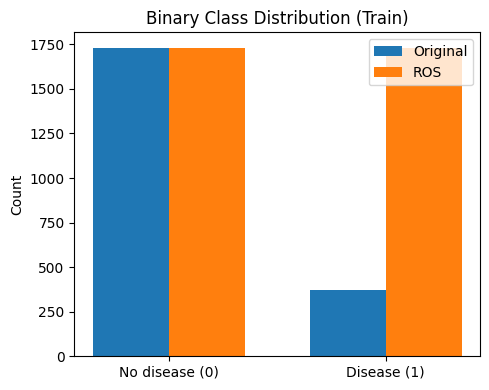

In [58]:
# ────────────────────────────────────────────
# Cell 19a: Binary Class Distribution (Original vs. ROS)
# ────────────────────────────────────────────

import matplotlib.pyplot as plt
import numpy as np

# Original training distribution
orig_counts = yb_train.value_counts().sort_index()
# After ROS (from Cell 16c)
ros_counts  = pd.Series(yb_bin_ros).value_counts().sort_index()

labels = ['No disease (0)', 'Disease (1)']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(5,4))
ax.bar(x - width/2, orig_counts, width, label='Original')
ax.bar(x + width/2, ros_counts,  width, label='ROS')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Count')
ax.set_title('Binary Class Distribution (Train)')
ax.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


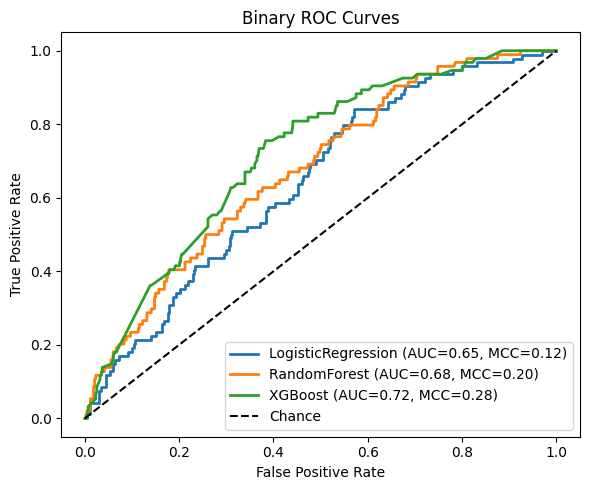

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


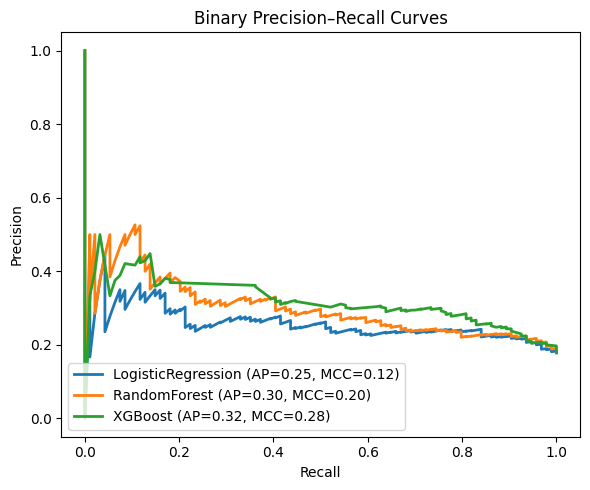

In [59]:
# ────────────────────────────────────────────
# Cell 19b: ROC & Precision–Recall Curves for All Binary Models
# ────────────────────────────────────────────

import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, precision_recall_curve,
    roc_auc_score, auc, matthews_corrcoef
)

# ROC
plt.figure(figsize=(6,5))
for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    y_pred  = model.predict(X_test)
    fpr, tpr, _ = roc_curve(yb_test, y_proba)
    roc_auc = roc_auc_score(yb_test, y_proba)
    mcc     = matthews_corrcoef(yb_test, y_pred)
    plt.plot(fpr, tpr,
             label=f"{name} (AUC={roc_auc:.2f}, MCC={mcc:.2f})",
             linewidth=2)
plt.plot([0,1], [0,1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Binary ROC Curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Precision–Recall
plt.figure(figsize=(6,5))
for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    y_pred  = model.predict(X_test)
    prec, rec, _ = precision_recall_curve(yb_test, y_proba)
    pr_auc       = auc(rec, prec)
    mcc          = matthews_corrcoef(yb_test, y_pred)
    plt.plot(rec, prec,
             label=f"{name} (AP={pr_auc:.2f}, MCC={mcc:.2f})",
             linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Binary Precision–Recall Curves")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


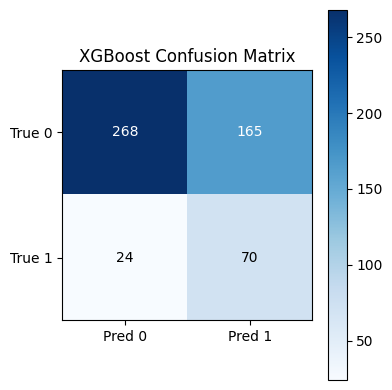

In [60]:
# ────────────────────────────────────────────
# Cell 19c: Binary Confusion Matrix Heatmap
# ────────────────────────────────────────────

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Use best binary model from Cell 18a
best_bin = best_models[best_name]
y_pred  = best_bin.predict(X_test)
cm      = confusion_matrix(yb_test, y_pred)

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i,j]>cm.max()/2 else "black")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Pred 0','Pred 1']); ax.set_yticklabels(['True 0','True 1'])
ax.set_title(f"{best_name} Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# feature_cols

array(['num__age_event', 'num__age_current', 'num__num_comorbidities',
       'num__race_asian', 'num__race_black', 'num__race_hawaiian',
       'num__race_native', 'num__race_other', 'num__race_white',
       'num__ethnicity_hispanic', 'num__ethnicity_nonhispanic',
       'num__mean_29463-7', 'num__mean_39156-5', 'num__mean_59576-9',
       'num__mean_63512-8', 'num__mean_63586-2', 'num__mean_70274-6',
       'num__mean_72514-3', 'num__mean_8302-2', 'num__mean_8462-4',
       'num__mean_8480-6', 'num__mean_8867-4', 'num__mean_9279-1',
       'num__min_29463-7', 'num__min_39156-5', 'num__min_59576-9',
       'num__min_63512-8', 'num__min_63586-2', 'num__min_70274-6',
       'num__min_72514-3', 'num__min_8302-2', 'num__min_8462-4',
       'num__min_8480-6', 'num__min_8867-4', 'num__min_9279-1',
       'num__max_29463-7', 'num__max_39156-5', 'num__max_59576-9',
       'num__max_63512-8', 'num__max_63586-2', 'num__max_70274-6',
       'num__max_72514-3', 'num__max_8302-2', 'num__max_8462-

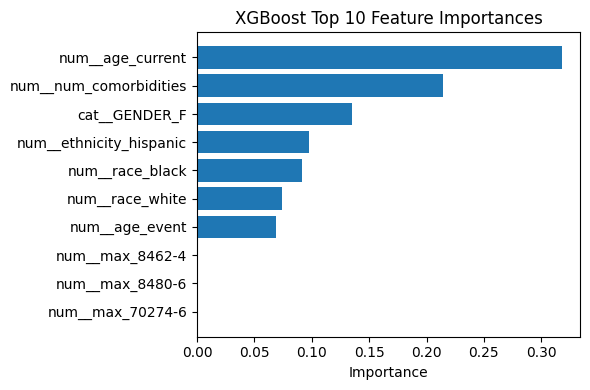

In [61]:
# ────────────────────────────────────────────
# Cell 19d: Binary Feature Importance (Top 10)
# ────────────────────────────────────────────

import numpy as np

clf = best_bin.named_steps['clf']
if hasattr(clf, 'feature_importances_'):
    imp = clf.feature_importances_
elif hasattr(clf, 'coef_'):
    imp = np.abs(clf.coef_).ravel()
else:
    raise ValueError("No feature importance available")
# feat_names = preprocessor.get_feature_names_out()
indices = np.argsort(imp)[-10:][::-1]  # top 10
fig, ax = plt.subplots(figsize=(6,4))
ax.barh(np.arange(10), imp[indices], align='center')
ax.set_yticks(np.arange(10))
ax.set_yticklabels(feature_cols[indices])
ax.invert_yaxis()
ax.set_xlabel("Importance")
ax.set_title(f"{best_name} Top 10 Feature Importances")
plt.tight_layout()
plt.show()


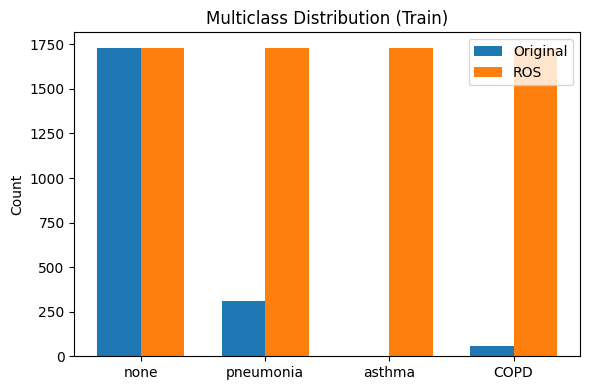

In [62]:
# ────────────────────────────────────────────
# Cell 20a: Multiclass Distribution (Original vs. ROS)
# ────────────────────────────────────────────

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

labels = ['none','pneumonia','asthma','COPD']

# Wrap the integer‐coded arrays in Series and map codes → label names
orig_mc = pd.Series(ymc_train).map(lambda x: labels[x]).value_counts().reindex(labels)
ros_mc  = pd.Series(ymc_mul_ros).map(lambda x: labels[x]).value_counts().reindex(labels)

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x - width/2, orig_mc, width, label='Original')
ax.bar(x + width/2, ros_mc,  width, label='ROS')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Count')
ax.set_title('Multiclass Distribution (Train)')
ax.legend()
plt.tight_layout()
plt.show()


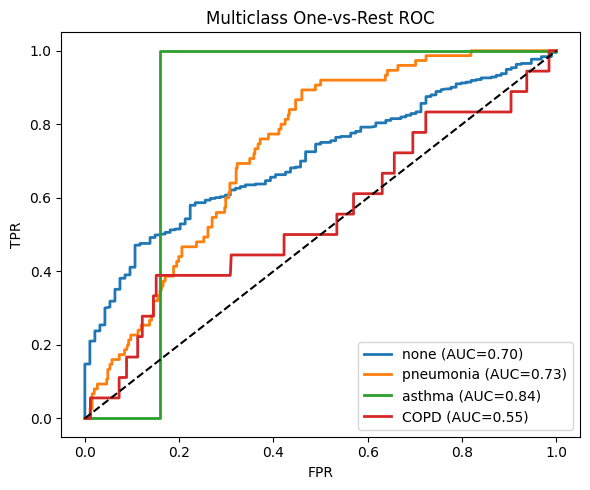

In [63]:
# ────────────────────────────────────────────
# Cell 20b: One-vs-Rest ROC Curves (Multiclass)
# ────────────────────────────────────────────

from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(6,5))
for i, cls in enumerate(labels):
    # get OVR curve
    y_true_bin = (ymc_test == i).astype(int)
    y_proba_i  = best_multi_models[best_name_mc].predict_proba(X_test)[:, i]
    fpr, tpr, _ = roc_curve(y_true_bin, y_proba_i)
    auc_i = roc_auc_score(y_true_bin, y_proba_i)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={auc_i:.2f})", linewidth=2)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Multiclass One-vs-Rest ROC")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


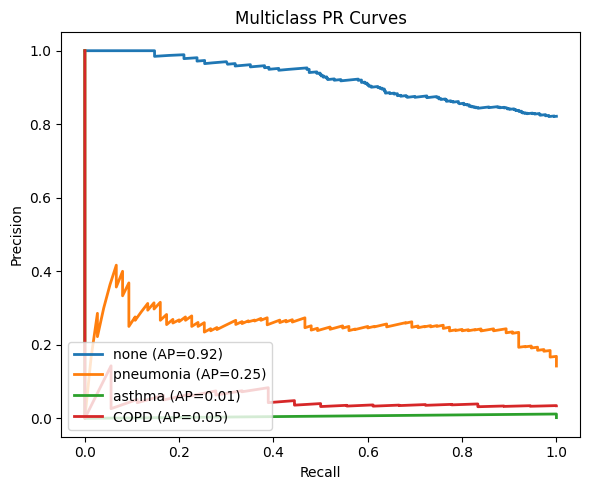

In [64]:
# ────────────────────────────────────────────
# Cell 20c: Precision–Recall Curves per Class (Multiclass)
# ────────────────────────────────────────────

from sklearn.metrics import precision_recall_curve, auc

plt.figure(figsize=(6,5))
for i, cls in enumerate(labels):
    y_true_bin = (ymc_test == i).astype(int)
    y_proba_i  = best_multi_models[best_name_mc].predict_proba(X_test)[:, i]
    prec, rec, _ = precision_recall_curve(y_true_bin, y_proba_i)
    pr_auc       = auc(rec, prec)
    plt.plot(rec, prec, label=f"{cls} (AP={pr_auc:.2f})", linewidth=2)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Multiclass PR Curves")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


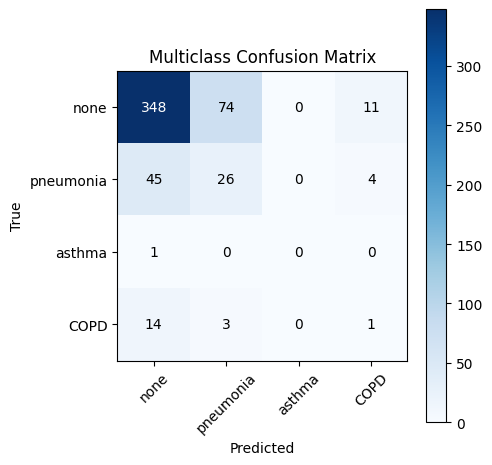

In [65]:
# ────────────────────────────────────────────
# Cell 20d: Multiclass Confusion Matrix Heatmap
# ────────────────────────────────────────────

from sklearn.metrics import confusion_matrix

cm_mc = confusion_matrix(ymc_test, best_model_mc.predict(X_test))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm_mc, cmap='Blues')
fig.colorbar(im, ax=ax)
for i in range(4):
    for j in range(4):
        ax.text(j, i, cm_mc[i,j], ha="center", va="center",
                color="white" if cm_mc[i,j]>cm_mc.max()/2 else "black")
ax.set_xticks(range(4)); ax.set_xticklabels(labels, rotation=45)
ax.set_yticks(range(4)); ax.set_yticklabels(labels)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_title("Multiclass Confusion Matrix")
plt.tight_layout()
plt.show()


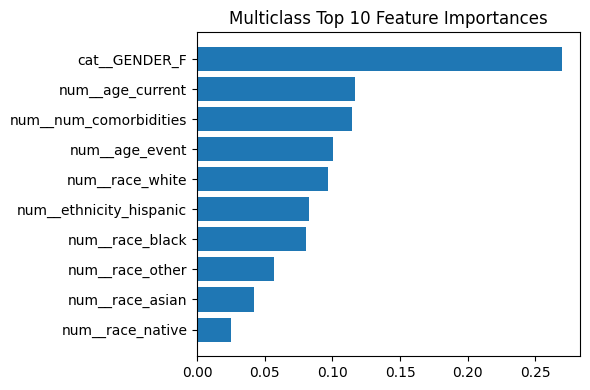

In [66]:
# ────────────────────────────────────────────
# Cell 20e: Per-Class Feature Importance (Multiclass)
# ────────────────────────────────────────────

clf_mc = best_model_mc.named_steps['clf']
if hasattr(clf_mc, 'feature_importances_'):
    importances = clf_mc.feature_importances_
    # For tree-based, just show overall top features
    idx = np.argsort(importances)[-10:][::-1]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.barh(np.arange(10), importances[idx])
    ax.set_yticks(np.arange(10))
    ax.set_yticklabels(feature_cols[idx])
    ax.invert_yaxis()
    ax.set_title("Multiclass Top 10 Feature Importances")
    plt.tight_layout()
    plt.show()
elif hasattr(clf_mc, 'coef_'):
    coefs = np.abs(clf_mc.coef_)           # shape: (n_classes, n_features)
    fig, axes = plt.subplots(2, 2, figsize=(10,8), sharex=True)
    for i, ax in enumerate(axes.flatten()):
        idx = np.argsort(coefs[i])[-5:][::-1]
        ax.barh(np.arange(5), coefs[i, idx])
        ax.set_yticks(np.arange(5))
        ax.set_yticklabels(feat_names[idx])
        ax.invert_yaxis()
        ax.set_title(f"{labels[i]} Importance")
    plt.tight_layout()
    plt.show()


In [ ]:
# Saving Pipelines

In [67]:
# Cell 21: Save Only the Best Performing Pipelines

import os
import pickle

# Ensure directory exists
os.makedirs("models", exist_ok=True)

# Save best binary model pipeline
binary_name = best_name  # from Cell 18a
binary_pipeline = best_models[binary_name]
binary_filename = f"models/best_binary_{binary_name.lower()}.pkl"
with open(binary_filename, "wb") as f:
    pickle.dump(binary_pipeline, f)
print(f"Saved binary pipeline: {binary_filename}")

# Save best multiclass model pipeline
mc_name = best_name_mc  # from Cell 18c
mc_pipeline = best_multi_models[mc_name]
mc_filename = f"models/best_multiclass_{mc_name.lower()}.pkl"
with open(mc_filename, "wb") as f:
    pickle.dump(mc_pipeline, f)
print(f"Saved multiclass pipeline: {mc_filename}")


Saved binary pipeline: models/best_binary_xgboost.pkl
Saved multiclass pipeline: models/best_multiclass_xgboost.pkl
